# Accessibility Analysis in Mumbai
## This analysis is unique in that it utilizes a road and a rail network
### Data Prep notes
The road network in this notebook is fetched via OSMNX. The rail network and the rail stations are seperate shapefiles. The rail network are lines, and the rail stations are points. It is highly encouraged that the rail stations be snapped to vertices on the rail network using GIS software.

In [1]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [2]:
#Get reference to OSMNX_POIs
sys.path.append(r'../..')
from Market_Access import OSMNX_POIs

In [3]:
#Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

networkx version: 2.2 
osmnx version: 0.9 


In [4]:
# maybe GOSTRocks is not absolutely needed
#Get reference to GOSTRocks
# you need to add your own reference here
#sys.path.append(r'/media/sf_data')
#from GOSTRocks import misc
#from GOSTRocks import osmMisc
#urbanParams = misc.getUrbanParams()

## Mapping travel times from households to jobs

We have data for 2,979 households (multiple people are sampled at each household). We are primarily looking to do two kinds of analysis. For both of the analyses described below, we will calculate accessibility according to three modes of transit:
1. OSM road network driving with standard road classes
2. Rail network (known) with walking to the rail station
3. Rail network (known and proposed) with walking to the rail station
 
First, identify the households which have individual work places identified, and calculate their travel time. Second, for every geocoded household, calculate job accessibilitiy indices.

1. Distance from residence to work place; estimated travel time
          a. Calculate Euclidean distance from house to workplace for each worker 
          b. Calculate distance from house to workplace using (i) road network; (ii) rail network; (iii) road & rail network 
          c. Calculate travel time via (a), (b), and (c)

2. Index of employment accessibility
          a. In addition to the information in 2., we have information on employment, by gender and industry for 88 Sections of Mumbai.
          b. We would like to combine this information with household location information from the survey to calculate an index of employment accessibility (separate index for men and women) for each household in the sample.
          c. The index would measure number of jobs accessible within a certain distance (or time, conditional on mode). 


Define input data and create a number of output datasets if they do not yet exist

In [5]:
inputFolder = r'./input_folder'

inJobs = os.path.join(inputFolder, "GREATER_MUMBAI.shp")
inputRailways = os.path.join(inputFolder, "Mumbai_Railway_MANUAL_43N.shp")
inputRailstops = os.path.join(inputFolder, "Mumbai_Railway_stations_MANUAL.shp")

# this data is not public
inputFolder2 = r'/media/sf_data/Mumbai_OD'

inHouseholds = os.path.join(inputFolder2, "Home and Work Locations.csv")
inJobDefinition = os.path.join(inputFolder2, "employment by section.csv")

inJ = gpd.read_file(inJobs)
inJD = pd.read_csv(inJobDefinition)
inJ = pd.merge(inJ, inJD, left_on="WARD_NO", right_on="section")
#inJ.to_file(inJobs.replace(".shp", "_withJobs.shp"))

# Read in the admin boundaries and extract the centroids
inJ_cen = inJ.copy()
inJ_cen['geometry'] = inJ_cen.centroid

outputFolder = r'../../../greater_mumbai_outputs'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

outRoads = os.path.join(outputFolder, "OSM_Roads.csv")
outGraph = os.path.join(outputFolder, "OSM_Roads.pickle")
outRailGraph = os.path.join(outputFolder, "OSM_Rail.pickle")
outComboGraph = os.path.join(outputFolder, "OSM_Combo.pickle")
outHouseholds = os.path.join(outputFolder, "unq_households.csv")

if not os.path.exists(outGraph):
    extent = box(*inJ.total_bounds)
    G = ox.graph_from_polygon(extent, network_type='drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    nx.write_gpickle(G, outGraph)
    roads = gn.edge_gdf_from_graph(G)
    roads['highway'] = roads.highway.astype(str)
    roads['oneway'] = roads.oneway.astype(int)
    roads['OSMLR'] = roads.highway.map(osmMisc.OSMLR_Classes)
    roads = roads[['highway','geometry','OSMLR','oneway']]
    #print('print roads')
    #roads[:10]
    roads.to_csv(outRoads)
else:
    G = nx.read_gpickle(outGraph)    
    G = gn.convert_network_to_time(G, 'length')

In [6]:
# double-check the road graph G
gn.example_edge(G, 3)

(2248802304, 2248802330, {'osmid': 215438684, 'highway': 'residential', 'oneway': False, 'length': 66.863, 'time': 12.035340000000001, 'mode': 'drive'})
(2248802313, 2248802342, {'osmid': 215438630, 'highway': 'residential', 'oneway': False, 'length': 101.67399999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f9c87fb1240>, 'time': 18.301319999999997, 'mode': 'drive'})
(6136332304, 4292746859, {'osmid': 289412579, 'oneway': True, 'highway': 'primary', 'length': 278.65, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f9c87fb11d0>, 'time': 25.078499999999995, 'mode': 'drive'})


In [7]:
# double-check the outRoads file
#outRoads
#df = pd.read_csv(outRoads, encoding='utf-8')
#df[:5]

### Inspect the input graph from OSMNX to see the input road edges and nodes

In [8]:
# from shapely.wkt import loads

In [9]:
# geometry = [loads(x) for x in df.geometry]
# print(geometry[0])
# crs = {'init': 'epsg:4326'} #http://www.spatialreference.org/ref/epsg/2263/
# geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
# geo_df.to_file(driver='ESRI Shapefile', filename=os.path.join(outputFolder,"outroads2.shp"),encoding='utf-8')

In [10]:
# from shapely.geometry import Point
# g_point_gdf = gn.node_gdf_from_graph(G,crs = {'init' :'epsg:4326'})
# g_point_gdf.to_file(driver = 'ESRI Shapefile', filename = os.path.join(outputFolder,"outroads_nodes2.shp"))

### Explore data and count the number of unique households with valid coordinates

In [11]:
#Identify the unique housing locations
if not os.path.exists(outHouseholds):
    inH = pd.read_csv(inHouseholds)
    householdLocations = pd.DataFrame(inH.groupby('household_id')[['gps_latitude_home', 'gps_longitude_home']].mean())
    householdLocations.to_csv(outHouseholds)
else:
    householdLocations = pd.read_csv(outHouseholds)

householdLocations['geometry'] = householdLocations.apply(lambda x: Point(x['gps_longitude_home'], x['gps_latitude_home']), axis=1)
hh_gpd = gpd.GeoDataFrame(householdLocations, geometry='geometry')
hh_gpd = hh_gpd[hh_gpd['geometry'].apply(lambda x: x.is_valid)]
hh_gpd.crs = {'init': u'epsg:4326'}
len(hh_gpd)

2979

# Generate the rail network
## snap the railway stations to the railway line vertices

In [12]:
#if not os.path.exists(outRailGraph):

#Read in the input railways check for problems, and project
inR = gpd.read_file(inputRailways)
inR = inR[[r is not None for r in inR.geometry]]
if inR.crs == {'init':'epsg:4326'}:
    #inR = misc.project_UTM(inR)
    print('skip')
inR = inR.to_crs({'init': 'epsg:32643'})
inR['length'] = inR['geometry'].apply(lambda x: x.length)

#Read in the railway stations and project
inS = gpd.read_file(inputRailstops)
inS = inS[inS['railway'] == "station"]
#inS_proj = misc.project_UTM(inS)
#
#inS_proj = {'init'='epsg:32643'}
inS_proj = inS.to_crs({'init': 'epsg:32643'})

print('check projection inS')
print(inS_proj.crs)

print('check projection inR')
print(inR.crs)

#Generate the Rail network from the rail shapefile
allRailLines = unary_union(inR['geometry'])

bag_of_points,ids = [],[]
id_ = 0
for r in allRailLines.geoms:
    for q in r.coords:
        bag_of_points.append(q)
        ids.append(id_)
        id_+=1

df_temp = pd.DataFrame(({'ids':ids,'geometry':bag_of_points}))
df_temp['geometry'] = df_temp['geometry'].apply(Point)
gdf_temp = gpd.GeoDataFrame(df_temp, crs = inR.crs, geometry = 'geometry')

# for testing temporarily export rail bag of points
#gdf_temp.to_file(driver = 'ESRI Shapefile', filename = 'pre_railine_points3.shp' )

# for testing temporarily export rail stations
#inS_proj.to_file(driver = 'ESRI Shapefile', filename = 'pre_station_points3.shp' )

# the source_crs should be the same proj than both the input graph and input geodataframe of points
# the rail points need to be snapped to the rail because later the snapped points will be used to split the rail
inS_proj_snapped = gn.pandana_snap_points(inS_proj, 
                                          gdf_temp, 
                                          source_crs = 'epsg:32643', 
                                          target_crs = 'epsg:32643',
                                          add_dist_to_node_col = True)

inS_proj_snapped_temp = inS_proj_snapped.drop_duplicates('NN')

# When the rail stations are snapped to the nearest node in the dataframe it is keeping the original geometries
# and it is adding only the NN id and the NN_distance columns

# Therefore join to the rail gdf to add the geometries of the nodes snapped to
inS_proj_snapped_temp = inS_proj_snapped_temp.rename(columns={"geometry": "original_geometry"})
inS_proj_snapped_temp_joined = inS_proj_snapped_temp.set_index('NN').join(gdf_temp.set_index('ids'))
inS_proj_snapped_temp_joined = inS_proj_snapped_temp_joined.reset_index()

# note when I had both original_geometry and geometry columns there was an error in outputting a shapefile
# it must have been confused with two geometry columns, therefore I am dropping the 'original_geometry' column
inS_proj_snapped_temp_joined_slim = inS_proj_snapped_temp_joined.drop(columns="original_geometry")
inS_proj_snapped_temp_joined_slim

#inS_proj_snapped_temp.keys()

inS_proj_snapped_temp_joined_geo = gpd.GeoDataFrame(inS_proj_snapped_temp_joined_slim, crs = inS_proj.crs, geometry = 'geometry')
# preview the snapped rail stations
inS_proj_snapped_temp_joined_geo.to_file(driver = 'ESRI Shapefile', filename = 'snapped_rail_stations3.shp' )

check projection inS
{'init': 'epsg:32643'}
check projection inR
{'init': 'epsg:32643'}


../../GOSTNets/GOSTNets/GOSTnet.py:1699: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(target_gdf[['x','y']].as_matrix())
../../GOSTNets/GOSTNets/GOSTnet.py:1701: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(source_gdf[['x','y']].as_matrix())


In [22]:
inS_proj_snapped_temp_joined_geo[:5]

,NN,full_id,osm_id,osm_type,name,network,railway,ref,wikidata,wikipedia,...,short_name,constructi,disused,proposed,alt_name_h,name_pa,highway,traffic_si,NN_dist,geometry
0,287,n213030669,213030669,node,Dahisar,None,station,DIC,Q5208848,en:Dahisar railway station,...,None,None,None,None,None,None,None,None,27.096695,POINT (275001.0781111507 2129854.901504612)
1,623,n213030714,213030714,node,Santacruz,IR,station,STC,Q7420001,en:Santacruz railway station,...,None,None,None,None,None,None,None,None,37.092462,POINT (272926.0703397002 2111281.305015021)
2,624,n347138797,347138797,node,Khar Road,IR,station,KHAR,Q372596,en:Khar Road railway station,...,None,None,None,None,None,None,None,None,0.000000,POINT (272701.2495459113 2109935.380538935)
3,212,n619280071,619280071,node,Wadala Road,IR,station,VDLR,Q7958939,en:Vadala Road railway station,...,None,None,None,None,None,None,None,None,25.964384,POINT (274654.9179273123 2104012.971955875)
4,277,n619992025,619992025,node,Kanjurmarg,IR,station,KJRD,Q6363526,en:Kanjurmarg railway station,...,None,None,None,None,None,None,None,None,5.935065,POINT (282073.3855235677 2116318.402315072)


In [23]:
bag_of_relevant_points = unary_union(inS_proj_snapped_temp_joined_geo.geometry)

## Split up the railway lines, then re-build it as a graph

In [24]:
# a shapely.ops function
split_geoms = split(allRailLines, bag_of_relevant_points)

print('print count of split geometries')
print(len(split_geoms))

geom_bag = []

for geom in split_geoms:
    g = geom.coords[0]
    h = geom.coords[-1]
    geom_bag.append(str(g))
    geom_bag.append(str(h))

ref = pd.DataFrame({'node_ids':range(0, len(geom_bag)),'geoms':geom_bag})
ref = ref.drop_duplicates('geoms')
ref = ref.set_index('geoms')

nodes = []
edges = []

for geom in split_geoms:
    u_data,v_data,edge_data = {},{},{}

    # start node
    # it is getting a reference to that node's coords
    u = ref['node_ids'].loc[str(geom.coords[0])]
    u_data['x'] = geom.coords[0][0]
    u_data['y'] = geom.coords[0][1]
    u_data['geom'] = Point(geom.coords[0])
    #u_data['string'] = str(geom.coords[0])

    # end node
    v = ref['node_ids'].loc[str(geom.coords[-1])]
    v_data['x'] = geom.coords[-1][0]
    v_data['y'] = geom.coords[-1][1]
    v_data['geom'] = Point(geom.coords[-1])
    #v_data['string'] = str(geom.coords[-1])

    # edge
    edge_data['geom'] = geom
    edge_data['length'] = geom.length

    nodes.append((u,u_data))
    nodes.append((v,v_data))
    edges.append((u,v,edge_data))
    edges.append((v,u,edge_data))

    id_ += 2

G_rail = nx.MultiDiGraph()
G_rail.add_nodes_from(nodes)
G_rail.add_edges_from(edges)
nx.write_gpickle(G_rail, outRailGraph)
#else:
    #G_rail = nx.read_gpickle(outRailGraph) 

print count of split geometries
90


In [25]:
gn.example_edge(G_rail, 3)

(0, 1, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c858ab128>, 'length': 1388.5881250266957})
(1, 0, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c858ab128>, 'length': 1388.5881250266957})
(1, 3, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c858ab470>, 'length': 813.9703934797164})


In [26]:
gn.example_node(G_rail, 3)

(0, {'x': 272122.66290875676, 'y': 2095693.7796779373, 'geom': <shapely.geometry.point.Point object at 0x7f9c858ab390>})
(1, {'x': 272366.8491270583, 'y': 2097048.817394499, 'geom': <shapely.geometry.point.Point object at 0x7f9c858ab400>})
(3, {'x': 272508.9179740083, 'y': 2097844.3993548118, 'geom': <shapely.geometry.point.Point object at 0x7f9c87fad828>})


## visualize network

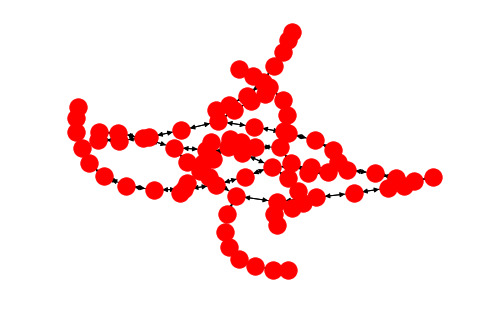

In [18]:
nx.draw(G_rail)

### Tests for the validity of the rail graph

In [27]:
# this is a test to export a shapefile for testing
list_of_Gs = list((nx.strongly_connected_component_subgraphs(G_rail)))
sz = 0
largest_G = list_of_Gs[0]
count = 0
for g in list_of_Gs:
    curSize = g.size()
    #print(curSize)
    if curSize > sz:
        largest_G = g
        sz = curSize
    #g_gdf = gn.edge_gdf_from_graph(g,crs = {'init' :'epsg:32643'})
    g_gdf = gn.edge_gdf_from_graph(g,crs = {'init' :'epsg:32643'})
    # for some reason has both a geom and geometry column
    g_gdf = g_gdf.drop(columns=['geom'])
    #print(g_gdf)
    filename = 'g_rail_gdf_test_%d.shp' % count
    #print(filename)
    g_gdf.to_file(driver = 'ESRI Shapefile', filename = filename )
    count += 1
    #print(count)
#G_rail_largest = largest_G
#G_rail_largest

In [28]:
gn.example_node(G_rail, 3)

(0, {'x': 272122.66290875676, 'y': 2095693.7796779373, 'geom': <shapely.geometry.point.Point object at 0x7f9c858ab390>})
(1, {'x': 272366.8491270583, 'y': 2097048.817394499, 'geom': <shapely.geometry.point.Point object at 0x7f9c858ab400>})
(3, {'x': 272508.9179740083, 'y': 2097844.3993548118, 'geom': <shapely.geometry.point.Point object at 0x7f9c87fad828>})


### Need to convert the graph node coordinates from UTM to WGS84

In [29]:
import importlib
importlib.reload(gn)

networkx version: 2.2 
osmnx version: 0.9 


<module 'GOSTnet' from '../../GOSTNets/GOSTNets/GOSTnet.py'>

In [30]:
# tested with one function before wrote the reproject_graph function
# from shapely.geometry import Point
# sample_point = Point(271620.51371866115,2101816.267494734)

# from shapely.ops import transform
# from functools import partial
# import pyproj

# project_WGS_UTM = partial(
#                 pyproj.transform,
#                 pyproj.Proj(init='epsg:32643'),
#                 pyproj.Proj(init='epsg:4326'))

# print(transform(project_WGS_UTM,sample_point))

In [31]:
G_rail_4326 = gn.reproject_graph(G_rail, 'epsg:32643', 'epsg:4326')

In [32]:
G_rail_4326
gn.example_node(G_rail, 8)

(0, {'x': 72.8360633305759, 'y': 18.940975234799453, 'geom': <shapely.geometry.point.Point object at 0x7f9c87ff1160>})
(1, {'x': 72.83822328429102, 'y': 18.95323998167732, 'geom': <shapely.geometry.point.Point object at 0x7f9c87ff19b0>})
(3, {'x': 72.83947921893387, 'y': 18.960440822411584, 'geom': <shapely.geometry.point.Point object at 0x7f9c87ff1e48>})
(4, {'x': 72.8435321130054, 'y': 19.017516410491485, 'geom': <shapely.geometry.point.Point object at 0x7f9c87ff17f0>})
(5, {'x': 72.8376614, 'y': 19.0094817, 'geom': <shapely.geometry.point.Point object at 0x7f9c858bd198>})
(7, {'x': 72.84434387789514, 'y': 18.96732091413225, 'geom': <shapely.geometry.point.Point object at 0x7f9c858a4c88>})
(9, {'x': 72.84414412090767, 'y': 18.978120836025376, 'geom': <shapely.geometry.point.Point object at 0x7f9c858a4a58>})
(11, {'x': 72.8440871427147, 'y': 18.987273139187, 'geom': <shapely.geometry.point.Point object at 0x7f9c858a4cc0>})


#### You can see that the coordinates of the road network are already in WGS84

In [33]:
gn.example_node(G, 3)

(2248802304, {'y': 19.0543562, 'x': 72.9334716, 'osmid': 2248802304})
(2248802313, {'y': 19.0543844, 'x': 72.9374888, 'osmid': 2248802313})
(6136332304, {'y': 19.0177024, 'x': 72.8727991, 'osmid': 6136332304})


## Set the rail speed and station wait time and merge the rail and road networks together

In [34]:
print('print inR.crs')
print(inR.crs['init'])

#inR = inR.to_crs({'init': 'epsg:4326'})

list_of_Gs = list((nx.strongly_connected_component_subgraphs(G)))
sz = 0
largest_G = list_of_Gs[0]
for g in list_of_Gs:
    curSize = g.size()
    if curSize > sz:
        largest_G = g
        sz = curSize
G = largest_G
print('print G')
print(sz)

print('print G_rail size')
print(G_rail.size())

#os.remove(outComboGraph)
#if not os.path.exists(outComboGraph):

##Required parameters in processing rail network
#railSpeed = 45 #kph
#station_wait = 120 #seconds
railSpeed = 50 #kph
station_wait = 15 #seconds
walk_speed = 1.5

#Convert Rail network length to time
for u, v, data in G_rail.edges(data=True):
    data['mode'] = 'rail'
    data['rail_time'] = ((data['length']/1000 / railSpeed) * 60 * 60) + station_wait
    data['time'] = 999999999 # driving time
    # the best time on the rail edges will be the rail times
    data['road_and_rail_time'] = ((data['length']/1000 / railSpeed) * 60 * 60) + station_wait

#Read in road network, calculate     
G = gn.convert_network_to_time(G, 'length') #Applies standard road speeds from OSM

for u, v, data in G.edges(data=True):
    data['mode'] = 'road'
    #Set the rail_time to walking time for the road network
    data['rail_time'] = ((data['length']/1000 / walk_speed) * 60 * 60)
    # the best time on the road edges will be the road times
    data['road_and_rail_time'] = data['time']

#Bind the graphs together
# There was problem with this originally. It seems like the GOSTNets function needs the input graphs to be in 4326
# but G_rail was in UTM

# join_networks will join the networks where the rail nodes (which are the stations) meet the road network nodes 
# within the threshold
# G_combo = gn.join_networks(G, G_rail, measure_crs=32643, thresh=300)
G_combo = gn.join_networks(G_rail,G,measure_crs=32643, thresh=300)
nx.write_gpickle(G_combo, outComboGraph)

#else:
#    G_combo = nx.read_gpickle(outComboGraph)
    
#Extract largest subgraph
list_of_Gs = list((nx.strongly_connected_component_subgraphs(G_combo)))
sz = 0
largest_G = list_of_Gs[0]
for g in list_of_Gs:
    curSize = g.size()
    if curSize > sz:
        largest_G = g
        sz = curSize
G_combo = largest_G
print('print G_combo size')
print(sz)

print inR.crs
epsg:32643
print G
73282
print G_rail size
180


../../GOSTNets/GOSTNets/GOSTnet.py:1645: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
../../GOSTNets/GOSTNets/GOSTnet.py:1647: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


print G_combo size
77604


#### Inspect the output of the combo graph

In [35]:
G_combo
i = list(G_combo.edges(data = True))[66700]
i

(24792,
 24765,
 {'osmid': 211658597,
  'highway': 'residential',
  'oneway': False,
  'length': 207.885,
  'geometry': <shapely.geometry.linestring.LineString at 0x7f9c835980f0>,
  'time': 37.4193,
  'mode': 'road',
  'rail_time': 498.92400000000004,
  'road_and_rail_time': 37.4193})

### Test to visually inspect the joined graph (optional)

In [37]:
# inspect G_combo
#g_combo_gdf = gn.edge_gdf_from_graph(G_combo,crs = {'init' :'epsg:4326'})
# for some reason has both a geom and geometry column
#g_combo_gdf = g_combo_gdf.drop(columns=['geom','osmid','junction', 'ref','lanes', 'bridge',
#       'maxspeed', 'width', 'access','Wkt', 'infra_type','time', 'road_and_rail_time', 'rail_time',
#       'highway', 'oneway', 'service', 'length', 'name', 'mode', 'tunnel'])
#print(g_combo_gdf.keys())
#print(g_combo_gdf)
#g_combo_gdf.to_file(driver = 'ESRI Shapefile', filename = 'g_combo4.shp' )

## Run analysis 1 - Distance from each individual to work

In [49]:
# 1. Distance from residence to work place; estimated travel time
#          a. Calculate Euclidean distance from house to workplace for each worker 
#          b. Calculate travel time from house to workplace using (i) road network; (ii) rail network ; (iii) road & rail network
inH = pd.read_csv(inHouseholds)
#Get reference to the individuals who work and get nodes
hh = inH[~inH['Ward in Which Person Works'].isnull()]
hh['geometry'] = hh.apply(lambda x: Point(x['gps_longitude_home'], x['gps_latitude_home']), axis=1)
hh = gpd.GeoDataFrame(hh, geometry="geometry")
hh.crs = {'init': 'epsg:4326'}
hh = hh.reset_index()
hh = hh[[x.is_valid for x in hh['geometry']]]

#look into warning below
# snapping each individual location to the combo graph
hh_nn = gn.pandana_snap(G_combo, hh)
hh_nn = hh_nn[['individual_id','Ward in Which Person Works','NN', 'gps_latitude_home','gps_longitude_home']]
hh_nn.columns = ['individual_id', "WARD_NO","hhNN", "hhlat", "hhlon"]

print('hh_nn count')
print(len(hh_nn.index))

/home/vagrant/miniconda3/envs/GOST_PublicGoods4/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


hh_nn count
3090


In [89]:
#hh
#inJ_cen

In [90]:
# Get nodes for the input admin
# snapping the employment by ward centroids to the combo graph
det_nn = gn.pandana_snap(G_combo, inJ_cen)
det_nn = det_nn[['WARD_NO', 'NN', 'geometry']]
# make a lat and lon column from the det_nn geometry column
det_nn_gpd = gpd.GeoDataFrame(det_nn, geometry="geometry")
det_nn_gpd['detlat'] = det_nn_gpd['geometry'].y
det_nn_gpd['detlon'] = det_nn_gpd['geometry'].x
det_nn_gpd.columns = ['WARD_NO', "wardNN", "geometry", "detlat", "detlon"]
det_nn_gpd = det_nn_gpd.drop(columns="geometry")

In [91]:
det_nn_gpd[:5]

,WARD_NO,wardNN,detlat,detlon
0,74,23780,19.260077,72.863674
1,73,20527,19.245660,72.871931
2,73,3160,19.219229,72.870747
3,71,25697,19.239959,72.801937
4,70,16045,19.246712,72.853009


In [92]:
print('det_nn count')
print(len(det_nn.index))

# Combine Data
# The default is 'inner', which is like a SQL inner join, which selects all rows from both tables as long as there is a match between the columns
# In this case, only the rows that contain WARD_NO values that are common between hh_nn and det_nn remain in the merged data
# This can explain how there are less rows after the merge, for example the '99' ward values don't exist in the ward centroids dataset
comboData = pd.merge(hh_nn, det_nn_gpd, on='WARD_NO')

print('comboData count')
print(len(comboData.index))

det_nn count
99
comboData count
2828


In [93]:
comboData[:5]

,individual_id,WARD_NO,hhNN,hhlat,hhlon,wardNN,detlat,detlon
0,65002_1,16.0,8914,19.206719,72.834494,20267,18.95957,72.817973
1,67504_1,16.0,2631,19.200118,72.879166,20267,18.95957,72.817973
2,67801_1,16.0,28056,19.206733,72.851537,20267,18.95957,72.817973
3,68501_1,16.0,3095,19.200800,72.865074,20267,18.95957,72.817973
4,65402_3,16.0,24245,19.204746,72.832417,20267,18.95957,72.817973


In [94]:
import importlib
importlib.reload(gn)

networkx version: 2.2 
osmnx version: 0.9 


<module 'GOSTnet' from '../../GOSTNets/GOSTNets/GOSTnet.py'>

In [98]:
# Driving, Rail, and Driving & Rail distance from the individual to their workplace
drive_Vals = []
rail_Vals = []
drive_and_rail_Vals = []
euclidean_Vals = []
for idx, row in comboData.iterrows():
    distance1 = nx.shortest_path_length(G_combo, row['hhNN'], row['wardNN'], weight='time')
    drive_Vals.append(distance1)
comboData['driveToWork'] = drive_Vals
for idx, row in comboData.iterrows():
    distance2 = nx.shortest_path_length(G_combo, row['hhNN'], row['wardNN'], weight='rail_time')
    rail_Vals.append(distance2)
comboData['railToWork'] = rail_Vals
for idx, row in comboData.iterrows():
    distance3 = nx.shortest_path_length(G_combo, row['hhNN'], row['wardNN'], weight='road_and_rail_time')
    drive_and_rail_Vals.append(distance3)
comboData['DriveandRailToWork'] = drive_and_rail_Vals
for idx, row in comboData.iterrows():
    euclidean_distance = gn.euclidean_distance(row['hhlat'], row['hhlon'], row['detlat'], row['detlon'])
    euclidean_Vals.append(euclidean_distance)
comboData['euclidean_distance'] = euclidean_Vals
xx = pd.merge(inH, comboData, on='individual_id', how='left')
xx.to_csv(inHouseholds.replace(".csv", "_all_Distances.csv"))

## Run analysis 2 - household access index

In [ ]:
#Identify the originNodes
hh_nn = gn.pandana_snap(G_combo, hh_gpd)
originNodes = hh_nn['NN'].unique()

In [ ]:
#Identify destinationNodes
det_nn = gn.pandana_snap(G_combo, inJ_cen)
destNodes = det_nn['NN'].unique()

In [ ]:
#Calculate OD matrix
od_driving = gn.calculate_OD(G_combo, originNodes, destNodes, fail_value=-1, weight='time')
od_rail = gn.calculate_OD(G_combo, originNodes, destNodes, fail_value=-1, weight='rail_time')
od_driving_and_rail = gn.calculate_OD(G_combo, originNodes, destNodes, fail_value=-1, weight='road_and_rail_time')

In [ ]:
# Calculate the gravity weighted jobs access for driving & rail, as well as for total workers, male, and female)
# note that the origins do not have weights in this scenario
hh_out = hh_nn.copy()
results = {}
# why are originWeights 2?
#originWeights = 2
originWeights = 1
#dist_decay = 1
# dist_decay represents a half-life of 1 hour
dist_decay = .00019
decayFunction = lambda x: np.exp(-1 * dist_decay * x)

#just testing
#decayFunction = lambda x: x

for odType in ['driving', 'rail', 'od_driving_and_rail']:
    od = od_driving
    if odType == "rail":
        od = od_rail
    if odType == "od_driving_and_rail":
        od = od_driving_and_rail
    for weightColumn in ['TOTAL_WORKERS','male_num','female_num']:
        
        destWeights = det_nn[weightColumn]
        #print(destWeights)
        # I think we should normalize the destination weights using min-max normalization
        destWeights_normalized = destWeights.copy()
        destWeights_normalized = (destWeights_normalized - destWeights_normalized.min())/(destWeights.max()-destWeights.min())
        #destWeights_normalized = 1
        
        #maxTime = od.max()
        #normalized_OD = od / maxTime

        normalized_OD = od
        
        # this zeros out the outOD matrix
        outOD = od * 0
        
        for row in range(0, od.shape[0]):
            curRow = normalized_OD[row,:]
            decayedRow = decayFunction(curRow)
            weightedRow = decayedRow * destWeights_normalized * originWeights
            outOD[row,:] = weightedRow

        #Calculate the origin sum weights for each node
        weightedDistance = np.sum(outOD, axis=1)
        
        #try out not normalizing here
        #weightedDistance = weightedDistance/np.min(weightedDistance)
        
        resultweights = pd.DataFrame([originNodes, weightedDistance]).transpose()
        colName = "%s_%s" % (odType, weightColumn)
        resultweights.columns = ['NN', colName]
        results[colName] = resultweights
        hh_out = pd.merge(hh_out, resultweights, on="NN")
        
hh_out.to_csv(os.path.join(inputFolder, "weighted_distance_all_JOBS12_DD%s.csv" % dist_decay))